In [28]:
import sys
from pathlib import Path

# Add project root to sys.path so `src/` can be imported
sys.path.append(str(Path("..").resolve()))


In [29]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from dotenv import load_dotenv
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow


In [30]:
# === 1. Load tabular data ===
df = pd.read_parquet("../data/transformed/tabular_data.parquet")

# Rename cols for compatibility with shared pipeline
df = df.rename(columns={
    "start_hour": "pickup_hour",
    "start_station_id": "pickup_location_id"
})


In [31]:
# === 2. Train/Test split ===
X_train, y_train, X_test, y_test = split_time_series_data(
    df=df,
    cutoff_date=datetime(2024, 4, 1),
    target_column="target"
)


In [32]:
# === 3. Drop non-feature columns ===
drop_cols = ["pickup_hour", "pickup_location_id"]
X_train_model = X_train.drop(columns=drop_cols)
X_test_model = X_test.drop(columns=drop_cols)


In [33]:
# === 4. Train LightGBM Model ===
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train_model, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19926
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 672
[LightGBM] [Info] Start training from score 0.490260
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(random_state=42)

In [34]:
# === 5. Predict & Evaluate ===
predictions = model.predict(X_test_model).astype(int)
mae = mean_absolute_error(y_test, predictions)
print(f"📉 MAE (LightGBM, all 28-day lags): {mae:.4f}")

📉 MAE (LightGBM, all 28-day lags): 1.1889


# Feature Reduction

Top 10 features by importance:
Index(['rides_t-464', 'rides_t-44', 'rides_t-55', 'rides_t-1', 'rides_t-5',
       'rides_t-29', 'rides_t-247', 'rides_t-372', 'rides_t-60', 'rides_t-84'],
      dtype='object')


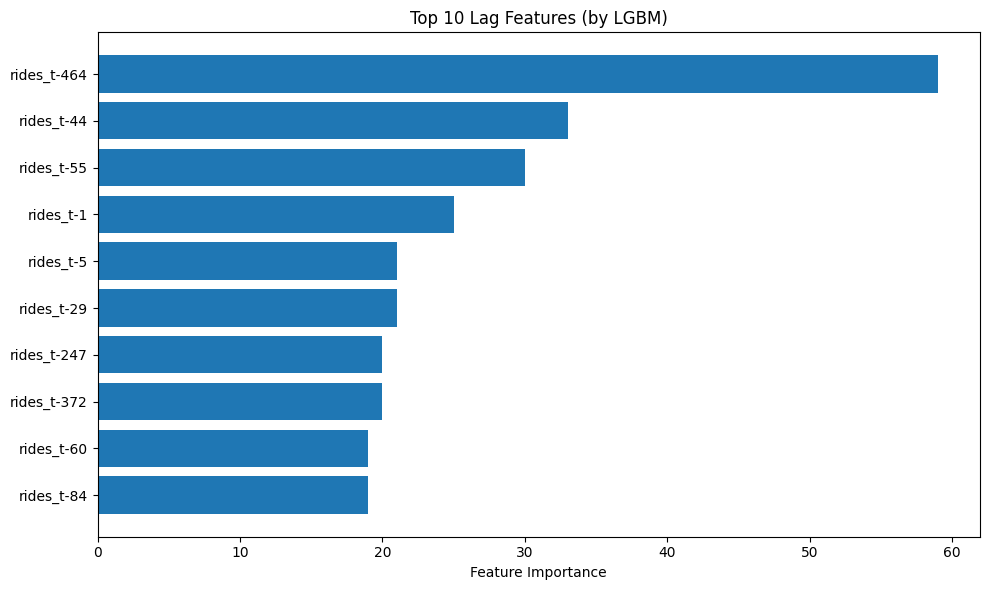

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have this from notebook 08
full_model = model  # Your trained LGBM model
full_feature_names = X_train_model.columns
importances = full_model.feature_importances_

# Get top 10 features
top_10_idx = np.argsort(importances)[-10:][::-1]
top_10_features = full_feature_names[top_10_idx]

print("Top 10 features by importance:")
print(top_10_features)

# Optional: visualize them
plt.figure(figsize=(10, 6))
plt.barh(top_10_features[::-1], importances[top_10_idx][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Lag Features (by LGBM)")
plt.tight_layout()
plt.show()


In [36]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from dotenv import load_dotenv
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

# Filter training/testing data
X_train_reduced = X_train_model[top_10_features]
X_test_reduced = X_test_model[top_10_features]

# Train reduced model
reduced_model = LGBMRegressor(random_state=42)
reduced_model.fit(X_train_reduced, y_train)

# Evaluate
predictions = np.round(reduced_model.predict(X_test_reduced)).astype(int)
mae = mean_absolute_error(y_test, predictions)
print(f"📉 MAE (LGBM, top 10 lags): {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 10
[LightGBM] [Info] Start training from score 0.490260
📉 MAE (LGBM, top 10 lags): 1.5222


In [37]:
load_dotenv()
mlflow = set_mlflow_tracking()

log_model_to_mlflow(
    model=reduced_model,
    input_data=X_test_reduced,
    experiment_name="LGBM_Top10_Features",
    metric_name="mae",
    score=mae,
    params=reduced_model.get_params()
)


INFO:src.experiment_utils:MLflow tracking URI and credentials set.
INFO:src.experiment_utils:Experiment set to: LGBM_Top10_Features
INFO:src.experiment_utils:Logged parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
INFO:src.experiment_utils:Logged mae: 1.5222222222222221
c:\Users\vidyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

🏃 View run sassy-lamb-611 at: https://dagshub.com/vidyuthkrishna03/citibike-ride-prediction.mlflow/#/experiments/2/runs/1da1be11f1974f67905f21fcb4741c7e
🧪 View experiment at: https://dagshub.com/vidyuthkrishna03/citibike-ride-prediction.mlflow/#/experiments/2


In [27]:
from src.plot_utils import plot_aggregated_time_series
import pandas as pd
predictions_series = pd.Series(predictions, index=X_test_reduced.index)
plot_aggregated_time_series(X_test, y_test, row_id=50, predictions=predictions_series).show()
